In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'covidqu:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1210221%2F3122958%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240325%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240325T102814Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D56d1c7fb139964bbdc57b00b3ebfd979352847fb15878223b620ae3146f94d75fccf853b20e0d89ec093b0e51203076896629e6cce5eb42b6716ce868bec5ffb27fa35ccc08f7ecb20ed93d8f2a9334d2439b0221830663a19f70028b881841d0f47e7854f44b14cf6bb0876b54ffffb0a2d7cf79670285fd08f2351fbc5ecee615504558a29f4f57c43974122f6cf2a0af0b01ac05f301c72c22d5a24e4cf1e4f665a51d5136c0d943b84fcc917482d69258f63073b877c6a7ee8bff826513b55d40452f9ac798b23f22e03f82437622a12288b793c47ec75d64b64888a3bdfd5f62e068e2e221a3eb0acd238512697a28600b82a0dc15fecdd5e3dbbb823f0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1236955718 bytes downloaded
Downloaded and uncompressed: covidqu
Data source import complete.


## Import packages


In [3]:
import os
import math
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
NUM_CLASSES = 3
CLASSES = ['COVID-19', 'Non-COVID', 'Normal']

IMAGE_SIZE = (224, 224)
EPOCHS = 50
LR = 1e-4
BATCH_SIZE = 32

## Preparing data


In [5]:
train_dir = '/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/'
test_dir = '/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test'
val_dir = '/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val'

In [6]:
def create_dataframe_from_directory(data_dir):
    filenames, labels = [], []
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name, 'images')
        list = [os.path.join(folder_name, 'images', filename)
                for filename in os.listdir(folder_path)]
        filenames.extend(list)
        labels.extend([folder_name] * len(list))
    return pd.DataFrame({
        'filename': filenames,
        'label': labels
    })


train_df = create_dataframe_from_directory(train_dir)
val_df = create_dataframe_from_directory(val_dir)
test_df = create_dataframe_from_directory(test_dir)


In [7]:
NUM_TRAINING_IMAGES = len(train_df.index)
NUM_VALIDATION_IMAGES = len(val_df.index)
NUM_TEST_IMAGES = len(test_df.index)

STEPS_PER_EPOCH = int(np.ceil(NUM_TRAINING_IMAGES / BATCH_SIZE))
VALIDATION_STEPS = int(np.ceil(NUM_VALIDATION_IMAGES / BATCH_SIZE))
TEST_STEPS = int(np.ceil(NUM_TEST_IMAGES / BATCH_SIZE))

print("Training images:", NUM_TRAINING_IMAGES)
train_label_counts = train_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in train_label_counts.items()]))
print()

print("Validation images:", NUM_VALIDATION_IMAGES)
val_label_counts = val_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in val_label_counts.items()]))
print()

print("Test images:", NUM_TEST_IMAGES)
test_label_counts = test_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in test_label_counts.items()]))


Training images: 3728
COVID-19: 1864, Normal: 932, Non-COVID: 932

Validation images: 932
COVID-19: 466, Normal: 233, Non-COVID: 233

Test images: 1166
COVID-19: 583, Non-COVID: 292, Normal: 291


In [8]:
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_set = data_aug.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)


Found 3728 validated image filenames belonging to 3 classes.


In [9]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

valid_set = data_gen.flow_from_dataframe(
    val_df,
    directory=val_dir,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)


Found 932 validated image filenames belonging to 3 classes.


In [10]:
test_set = data_gen.flow_from_dataframe(
    test_df,
    directory=test_dir,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 1166 validated image filenames belonging to 3 classes.


## Functions


In [11]:
def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    # return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
    #                             CLASSES[correct_label] if not correct else ''), correct
    return "{} [{}]".format(CLASSES[label], CLASSES[correct_label] if not correct else '\u2713'), correct


def display_one(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2),
                  color='red' if red else 'black', fontdict={'verticalalignment': 'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch(batch, predictions=None):
    images, labels = batch

    labels = np.argmax(labels, axis=1)
    # print(labels)
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 12.0
    SPACING = 0.1

    subplot = (rows, cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE, FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols, FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows, cols)*40+3
        # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one(image, title, subplot,
                              not correct, titlesize=dynamic_titlesize)

    # layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


In [12]:
def display_history(history):
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    ax[0].plot(history.history['loss'], color='b', label="training_loss")
    ax[0].plot(history.history['val_loss'], color='r',
               label="validation_loss", axes=ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['accuracy'],
               color='b', label="training_accuracy")
    ax[1].plot(history.history['val_accuracy'],
               color='r', label="validation_accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()


def display_confusion_matrix(
        cm, classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


## Training dataset visualizations


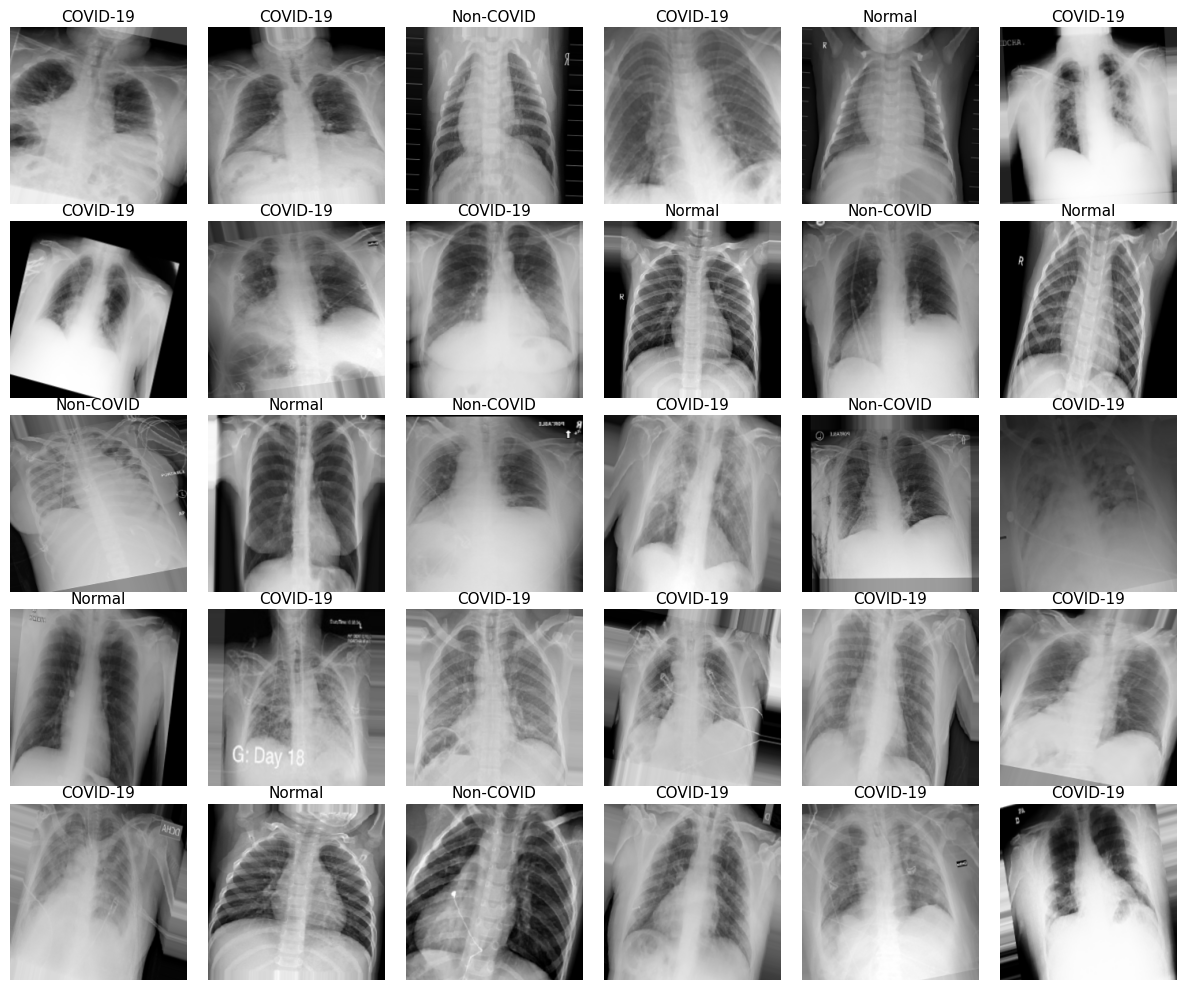

In [13]:
display_batch(next(iter(train_set)))


## Callbacks


In [14]:
reduce_lr_val_acc = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.2,
    min_lr=1e-6,
)

reduce_lr_val_loss = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

checkpoint = keras.callbacks.ModelCheckpoint(
    'best_xeception.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)


## Build model


In [15]:
baseModel = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

for layer in baseModel.layers:
    layer.trainable = False

x = baseModel.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=baseModel.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

83683744/83683744 [==============================] - 0s 0us/step


In [16]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

## Training


In [17]:
history = model.fit(
    train_set,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_set,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS,
    callbacks=[reduce_lr_val_acc, reduce_lr_val_loss, checkpoint]
)

model.save('xeception.h5')

Epoch 1/50
117/117 [==============================] - ETA: 0s - loss: 0.7868 - accuracy: 0.6612
Epoch 1: val_loss improved from inf to 0.66506, saving model to best_xeception.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


117/117 [==============================] - 69s 495ms/step - loss: 0.7868 - accuracy: 0.6612 - val_loss: 0.6651 - val_accuracy: 0.7403 - lr: 1.0000e-04
Epoch 2/50
117/117 [==============================] - ETA: 0s - loss: 0.6486 - accuracy: 0.7269
Epoch 2: val_loss improved from 0.66506 to 0.60786, saving model to best_xeception.h5
117/117 [==============================] - 57s 486ms/step - loss: 0.6486 - accuracy: 0.7269 - val_loss: 0.6079 - val_accuracy: 0.7650 - lr: 1.0000e-04
Epoch 3/50
117/117 [==============================] - ETA: 0s - loss: 0.5983 - accuracy: 0.7543
Epoch 3: val_loss improved from 0.60786 to 0.57498, saving model to best_xeception.h5
117/117 [==============================] - 56s 477ms/step - loss: 0.5983 - accuracy: 0.7543 - val_loss: 0.5750 - val_accuracy: 0.7886 - lr: 1.0000e-04
Epoch 4/50
117/117 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.7696
Epoch 4: val_loss did not improve from 0.57498
117/117 [==============================]

<Figure size 640x480 with 0 Axes>

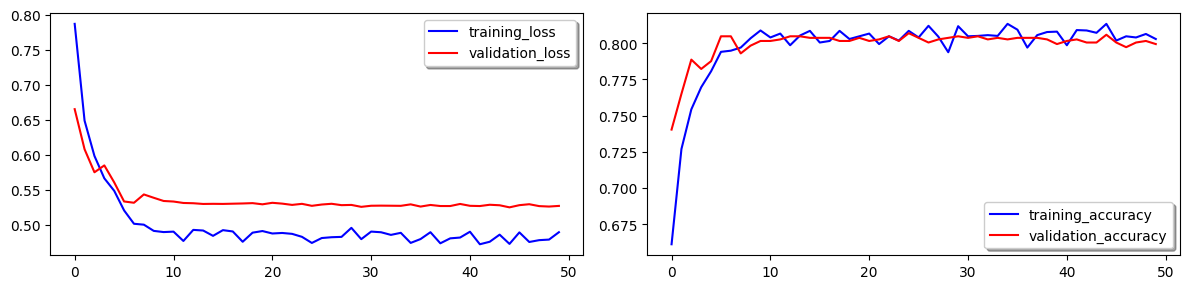

In [18]:
display_history(history)

## Evaluate


In [19]:
results = model.evaluate(valid_set)

print('Test loss: {:4f}'.format(results[0]))
print('Test accuracy: {:4f}'.format(results[1]))


30/30 [==============================] - 4s 118ms/step - loss: 0.5270 - accuracy: 0.7994
Test loss: 0.527007
Test accuracy: 0.799356


37/37 [==============================] - 7s 172ms/step
              precision    recall  f1-score   support

    COVID-19       0.90      0.86      0.88       583
   Non-COVID       0.79      0.72      0.75       292
      Normal       0.74      0.88      0.81       291

    accuracy                           0.83      1166
   macro avg       0.81      0.82      0.81      1166
weighted avg       0.83      0.83      0.83      1166



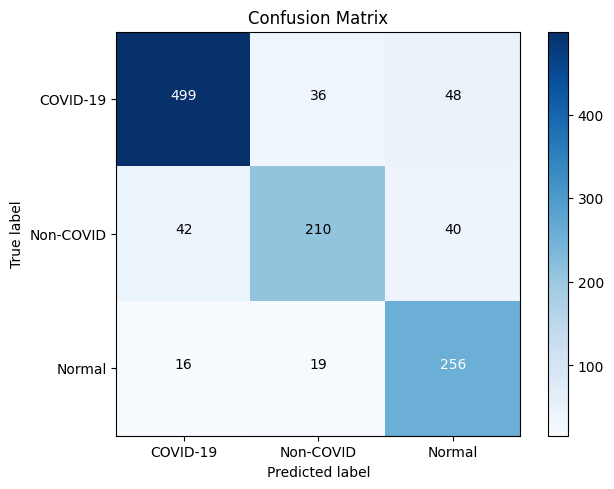

In [20]:
pred = model.predict(test_set, steps=TEST_STEPS)
y_pred = np.argmax(pred, axis=1)
y_true = test_set.classes

print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
display_confusion_matrix(cm=cm, classes=CLASSES, title='Confusion Matrix')

## Testing


In [21]:
batch = iter(test_set)

1/1 [==============================] - 1s 769ms/step


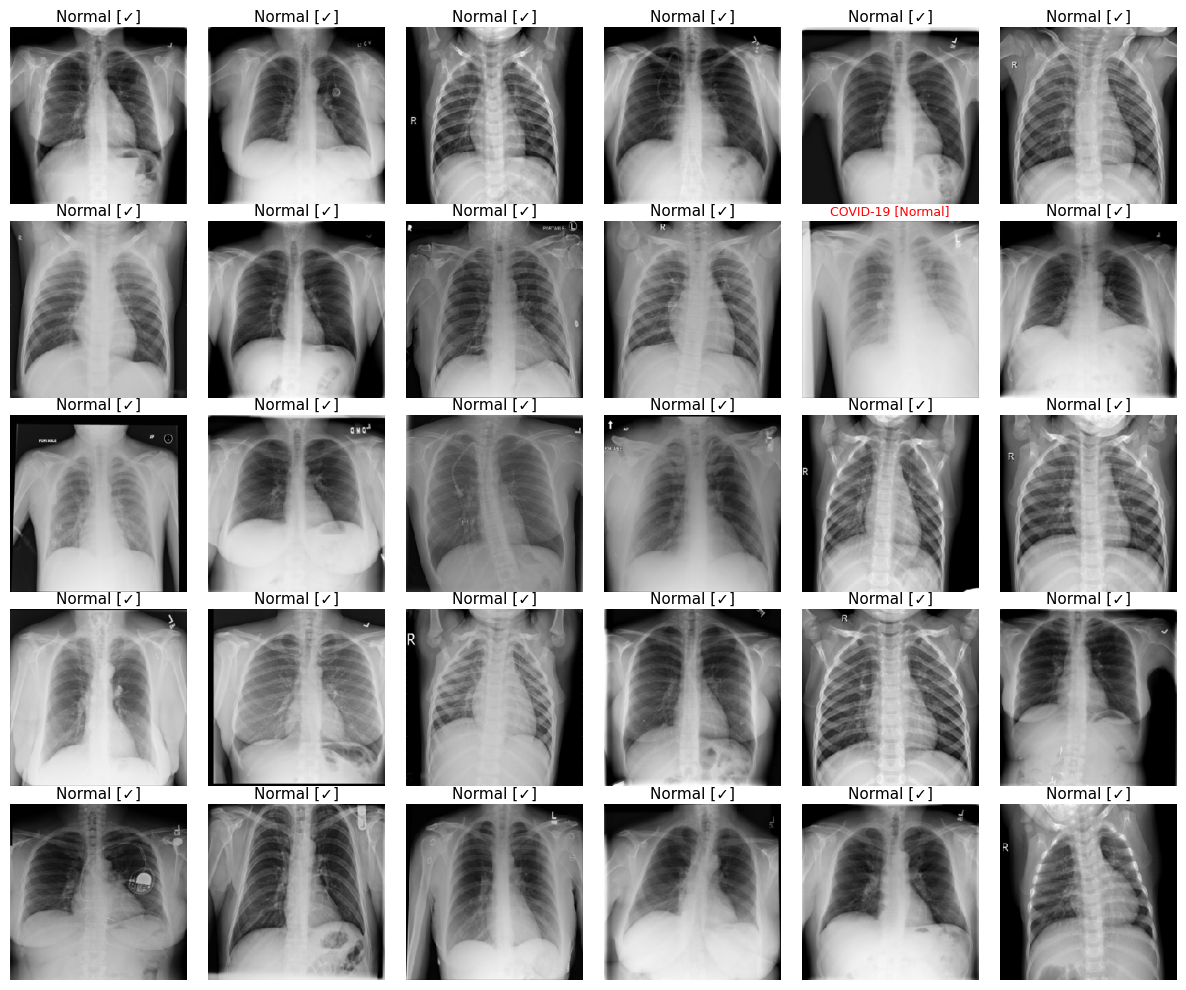

In [22]:
# run this cell again for next set of images
images, labels = next(batch)
predictions = np.argmax(model.predict(images), axis=-1)
display_batch((images, labels), predictions)